In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
#################################### 한글깨짐 ####################################
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")
##################################################################################

In [2]:
train = pd.read_csv("../bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("../bike-sharing-demand/test.csv", parse_dates=["datetime"])

In [3]:
# datetime컬럼 정리
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

In [22]:
train.info()
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  hour        10886 non-null  int64         
 15  dayofweek   10886 non-null  int64         
dtypes: datetime64[ns](1), 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [12]:
train.windspeed.value_counts()
test.windspeed.value_counts()
# season,weather,temp,atemp,humidity,month

0.0000     867
11.0014    638
8.9981     618
12.9980    615
7.0015     583
6.0032     553
15.0013    552
16.9979    471
19.0012    372
19.9995    316
22.0028    230
23.9994    186
26.0027    146
27.9993    109
30.0026     65
31.0009     57
32.9975     32
35.0008     26
39.0007     17
36.9974     17
40.9973     12
43.9989      3
46.0022      2
43.0006      2
54.0020      2
50.0021      1
55.9986      1
Name: windspeed, dtype: int64

In [26]:
# 풍속 데이터 0
wind_zero = train[train['windspeed']==0]
wind_zero_t = test[test['windspeed']==0]
# 풍속 데이터 존재
wind_num = train[train['windspeed']!=0]
wind_num_t = test[test['windspeed']!=0]
wind_num_concat = pd.concat([wind_num,wind_num_t],axis=0,ignore_index=True)

In [44]:
# 풍속 예측에 사용할 컬럼
w_col = ["season","weather","temp","atemp","humidity","month"]
w_xdata = wind_num_concat[w_col]
w_ylabel = wind_num_concat['windspeed'].astype('str')
# 풍속 채워줄 데이터
w0_train = wind_zero[w_col]
w0_test = wind_zero_t[w_col]

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
#SVM
clf = SVC()
clf.fit(w_xdata,w_ylabel)
# kfold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
#score
score = cross_val_score(clf, w_xdata, w_ylabel, cv=kfold,
                n_jobs=-1, scoring='accuracy')
np.mean(score)

0.11158631024566024

In [13]:
# 랜덤포레스트 기반 풍속 예측
def predictWindSpeed(train,test,data):
    # 풍속 데이터 0
    wind_zero = train[train['windspeed']==0]
    wind_zero_t = test[test['windspeed']==0]
    d_zero = data[data['windspeed']==0]
    # 풍속 데이터 존재
    wind_num = train[train['windspeed']!=0]
    wind_num_t = test[test['windspeed']!=0]
    wind_num_concat = pd.concat([wind_num,wind_num_t],axis=0,ignore_index=True)
    d_num = data[data['windspeed']!=0]
    # 풍속 예측 변수 선택
    # 풍속 예측에 사용할 컬럼
    w_col = ["season","weather","temp","humidity","month"]
    w_xdata = wind_num_concat[w_col]
    w_ylabel = wind_num_concat['windspeed'].astype('str')
    from sklearn.ensemble import RandomForestRegressor
    rfModelWind = RandomForestRegressor()
    rfModelWind.fit(w_xdata, w_ylabel)
    wind_zero_values = rfModelWind.predict(X=wind_zero[w_col])
    #predictWind_zero = wind_zero
    predictWind0 = d_zero
    predictWindNot0 = d_num
    predictWind0['windspeed'] = wind_zero_values
    data = predictWindNot0.append(predictWind0)
    data.reset_index()
    #data.drop('index', inplace=True, axis=1)
    return data

In [14]:
train = predictWindSpeed(train,test,train)

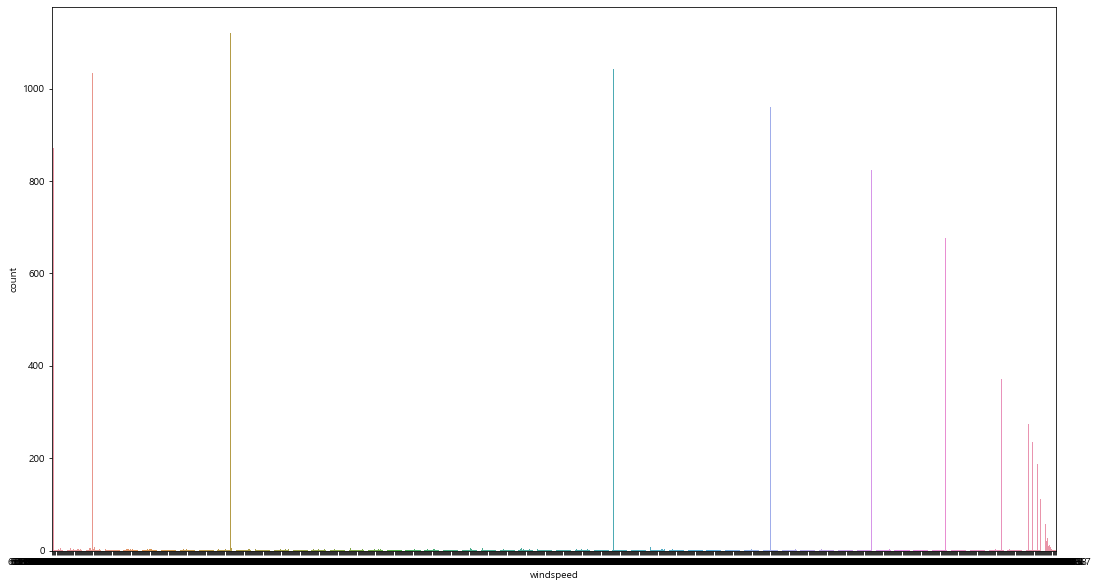

In [18]:
fig, axes = plt.subplots()
fig.set_size_inches(18,10)
sns.countplot(data=train, x = 'windspeed', ax=axes)

In [ ]:
# 모델로 풍속 예측하기
from sklearn.ensemble import RandomForestRegressor
label = train['count']
xData = train.drop(['datetime','casual','registered','count'],axis=1)
datetime_tmp = test.datetime
test = test.drop(['datetime'],axis=1)
rfModel = RandomForestRegressor()
rfModel.fit(xData, label)
prediction = rfModel.predict(test)
res = pd.DataFrame({'datetime':datetime_tmp ,'count':prediction})
res.to_csv("result.csv",index=False)
pd.read_csv("result.csv")

In [ ]:
figure, axes = plt.subplots() #구역나누기
figure.set_size_inches(18,8) # figure사이즈설정
sns.barplot(data=train, x='year', y='count', ax=ax1)